# Parte 4: Visualización de embeddings

Elegí realizar a consigna adicional de visualizar embeddings de campo `text` aplicando una técnica de reducción de dimensiones.

Incluyo visualizaciones del campo `text` vectorizado utilizando TF-IDF, Word2Vec preentrenado (GoogleNews-vectors-negative300.bin) y SBERT preentrenado (all-MiniLM-L6-v2). \
La reducción de dimensiones probé hacerlas con t-SNE y UMAP. Dejé en el notebook la que dio resultados con visualizaciones más claras en cada caso. En mi caso t-SNE dio mejores visualizaciones.

In [30]:
from sklearn.manifold import TSNE
import re
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy as np
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
CUSTOM_PALLETE = ["#00A7E1", "#FFA630"]

import pandas as pd
train_path = 'data/train.csv'
df = pd.read_csv(train_path)
def clean_text(s):
    s = str(s).lower()
    s = re.sub(r'http\S+', ' ', s)
    return s.strip()
df['text_emb'] = df['text'].apply(clean_text)

## TF-IDF

Para comenzar hago visualizaciones sobre una vectorización simple usando TF-IDF.

Es interesante notar la gran diferencia entre la reducción realizada por UMAP y por t-SNE. 

En la visualización de UMAP no hay un patrón distinguible que permita diferenciar en principio las dos clases, los puntos están bastante mezclados y dispersos. 

En cambio, en la visualización de t-SNE, si bien los datos siguen bastante mezclados se puede distinguir una clara "granularidad" mayor en esas mezclas. Se pueden distinguir claramente pequeños clusters donde se agrupan puntos de una misma clase. Un modelo de machine learning podría aprender a distinguir esas secciones donde se encuentran esas mayores concentraciones de los targets para hacer predicciones.

Son notables las superposiciones de puntos de diferente clase en los bordes de esas secciones, lo cual podría indicar que las predicciones sobre esos límites vayan a ser malas.

También es importante notar que las "formas" de las divisiones entre las secciones que contienen alta densidad de puntos pertenecientes a un mismo target son muy complejas, en otras palabras, puede resultar muy dificil para un modelo poder aprender de forma correcta esas divisiones.

c:\Users\Patricio\miniconda3\envs\tp3_env\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



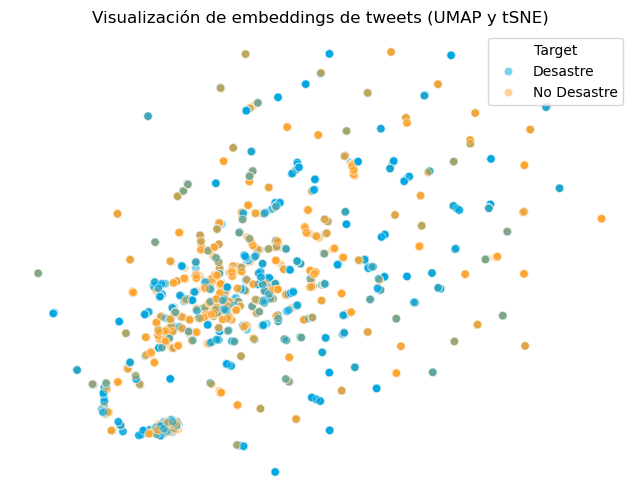

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=400, stop_words='english')
dim_reduc = UMAP(n_components=2, random_state=SEED)
X_embedded = vectorizer.fit_transform(df['text_emb'])
X_2d = dim_reduc.fit_transform(X_embedded.toarray())


df_plot = pd.DataFrame({
    'x': X_2d[:,0],
    'y': X_2d[:,1],
    'target': ['Desastre' if t == 1 else 'No Desastre' for t in df.target.values]
})
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_plot,
    x='x',
    y='y',
    hue='target',
    palette=CUSTOM_PALLETE,
    alpha=0.5
)
plt.title("Visualización de embeddings de tweets (UMAP y tSNE)")
plt.legend(title='Target')
plt.axis('off')
plt.show()

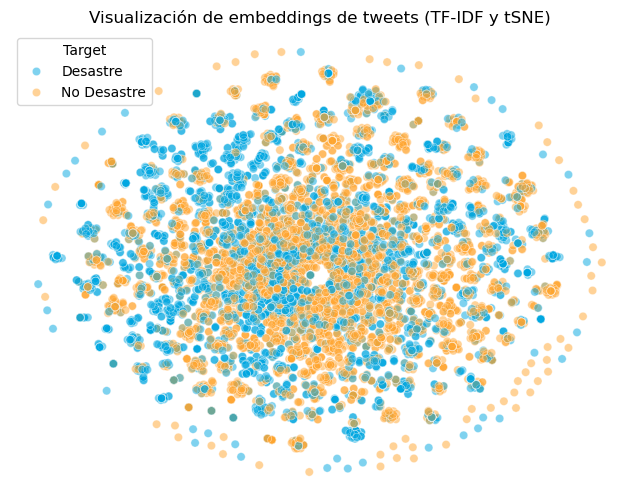

In [32]:
dim_reduc = TSNE(n_components=2, random_state=SEED, perplexity=40)
X_2d = dim_reduc.fit_transform(X_embedded.toarray())


df_plot = pd.DataFrame({
    'x': X_2d[:,0],
    'y': X_2d[:,1],
    'target': ['Desastre' if t == 1 else 'No Desastre' for t in df.target.values]
})
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_plot,
    x='x',
    y='y',
    hue='target',
    palette=CUSTOM_PALLETE,
    alpha=0.5
)
plt.title("Visualización de embeddings de tweets (TF-IDF y tSNE)")
plt.legend(title='Target')
plt.axis('off')
plt.show()

## Word2Vec

Utilizo un modelo de Word2Vec preentrenado que produce embeddings de 300 dimensiones.\
Como Word2Vec transforma palabras en vectores, y lo que necesitamos es transformar tweets (conjuntos de palabras) en vectores, hay que buscar alguna manera de combinar los vectores de palabras de un tweet para conseguir un vector único que represente el tweet.

Esto se puede hacer de diferentes formas, por ejemplo simplemente sumando los vectores de las palabras que conforman un tweet. \
Otra forma posible que me pareció interesante y que dio un gráfico interesante fue haciendo un promedio ponderado, utilizando los valores de TF-IDF de las palabras como pesos. Esta es la estrategia que adopté para la visualización, pero el resultado no es muy diferente que haciendo un promedio balanceado.

Podemos visualizar en el gráfico que ahora los puntos de las clases se separan de una forma notoriamente más sencilla. Parecería haber una frontera difusa que permite distinguir un grupo de mucha concentración de puntos naranjas a la derecha y puntos azules a la izquierda. Aún teniendo esta división con una forma más simple, también podemos ver que los puntos siguen estando bastante mezclados en las zonas donde hay más puntos.

In [33]:
from gensim.models import KeyedVectors
w2v_path = "GoogleNews-vectors-negative300.bin"
w2v = KeyedVectors.load_word2vec_format(w2v_path, binary=True)

In [34]:
feature_names = vectorizer.get_feature_names_out()
idf = dict(zip(feature_names, vectorizer.idf_))
max_idf = max(idf.values()) if idf else 1.0
tfidf_dict = {w: idf.get(w, 0.0)/max_idf for w in idf}

use_tfidf_weights = True
def sentence_vector_avg(tokens, model, dim):
    if use_tfidf_weights:
        vec = np.zeros(dim, dtype=float)
        w_sum = 0.0
        for w in tokens:
            wkey = w if w in model else (w.lower() if w.lower() in model else None)
            if wkey is None:
                continue
            tfidf_w = tfidf_dict.get(w, 0.0)
            vec += model[wkey] * tfidf_w
            w_sum += tfidf_w
        if w_sum == 0:
            return np.zeros(dim, dtype=float)
        return vec / w_sum
    else:
        if not tokens:
            return np.zeros(dim, dtype=float)
        vecs = []
        for w in tokens:
            if w in model:
                vecs.append(model[w])
            elif w.lower() in model:
                vecs.append(model[w.lower()])
        if len(vecs) == 0:
            return np.zeros(dim, dtype=float)
        return np.mean(vecs, axis=0)

token_pattern = re.compile(r"\w+")
def tokenize(text):
    return token_pattern.findall(text)
texts = df['text_emb'].astype(str).tolist()
tokens_list = [tokenize(t) for t in texts]

vecs = []
labels = []
for i in range(len(tokens_list)):
    tokens = tokens_list[i]
    v = sentence_vector_avg(tokens, w2v, dim=w2v.vector_size)
    vecs.append(v)
    labels.append(int(df.iloc[i]['target']))

w2v_embeddings = np.vstack(vecs)

In [35]:
dim_reduc = TSNE(n_components=2, random_state=SEED)
X_2d = dim_reduc.fit_transform(w2v_embeddings)

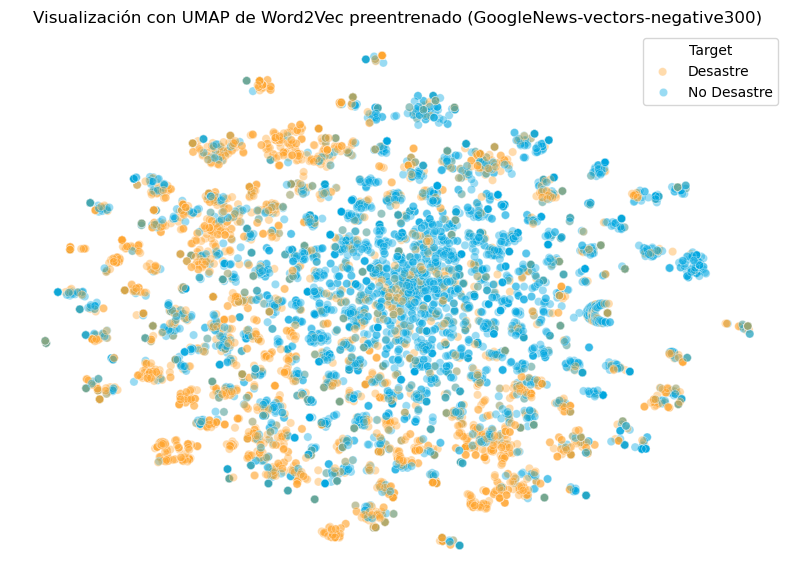

In [36]:
plt.figure(figsize=(10,7))
sns.scatterplot(
    x=X_2d[:,0],
    y=X_2d[:,1],
    hue=labels,
    palette=CUSTOM_PALLETE,
    alpha=0.4
)
plt.title('Visualización con UMAP de Word2Vec preentrenado (GoogleNews-vectors-negative300)')
plt.legend(title='Target', labels=['Desastre', 'No Desastre'])
plt.axis('off')
plt.show()


## SBERT

A continuación muestro una visualización utilizando el mismo embedding preentrenado de SentenceTransformers que utilicé para los modelos de la parte 2 y 3.

In [37]:
from sentence_transformers import SentenceTransformer

texts = df['text_emb'].astype(str).tolist()
y = df['target'].astype(int).values

model_name = "all-MiniLM-L6-v2"
print("Cargando SentenceTransformer:", model_name)
sbert = SentenceTransformer(model_name)

Cargando SentenceTransformer: all-MiniLM-L6-v2


In [38]:
sbert_embeddings = sbert.encode(texts, show_progress_bar=True, batch_size=64, convert_to_numpy=True)

Batches:   0%|          | 0/119 [00:00<?, ?it/s]

Se puede apreciar un resultado sorprendentemente similar al producido utilizando los vectores de Word2Vec. \
La diferencia que noto es que en este gráfico se pueden notar clústeres más densos de puntos de Desastres, lo cual podría facilitar la decisión de un modelo de aprendizaje automático cuando un punto cayera en esos espacios.

También puede notarse que, a grandes rasgos, la frontera entre los dos grandes grupos de desastre/no desastre es más difusa y se mezclan más.

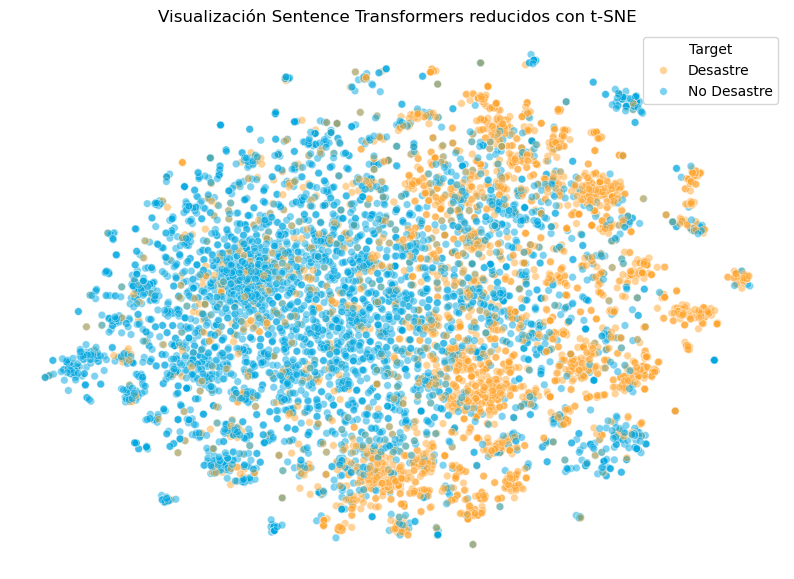

In [39]:
reducer = TSNE(n_components=2, random_state=SEED, perplexity=30)
X_2d = reducer.fit_transform(sbert_embeddings)

df_plot = pd.DataFrame({
    'x': X_2d[:,0],
    'y': X_2d[:,1],
    'target': y
})
df_plot['target_name'] = df_plot['target'].map({0: 'No Desastre', 1: 'Desastre'})

plt.figure(figsize=(10,7))
ax = sns.scatterplot(data=df_plot, x='x', y='y', hue='target_name',
                     palette=CUSTOM_PALLETE[::-1], alpha=0.5, s=30)
ax.set_title("Visualización Sentence Transformers reducidos con t-SNE")
plt.legend(title='Target')
plt.axis('off')
plt.show()


In [40]:
dim_reduc = TSNE(n_components=3, random_state=SEED)
embeddings_3d = dim_reduc.fit_transform(sbert_embeddings)

Por último incluyo una visualización 3d de este último embedding.

In [41]:
import plotly.express as px
y_str = df.target.map({0: 'No Desastre', 1: 'Desastre'}).astype(str)
df_plot = pd.DataFrame({
    'Dim1': embeddings_3d[:, 0],
    'Dim2': embeddings_3d[:, 1],
    'Dim3': embeddings_3d[:, 2],
    'Target': y_str,
    'Text': df['text_emb'].str[:50] + '...'
})
df_subset = df_plot.sample(frac=0.5, random_state=SEED)
# Gráfico interactivo
fig = px.scatter_3d(
    df_subset,
    x='Dim1', y='Dim2', z='Dim3',
    color='Target',
    hover_name='Text',
    hover_data={
        'Dim1': False, 
        'Dim2': False, 
        'Dim3': False, 
        'Target': True, 
        'Text': False
    },
    title='t-SNE 3D de Embeddings SBERT',
    color_discrete_map={'No Desastre': CUSTOM_PALLETE[0], 'Desastre': CUSTOM_PALLETE[1]}
)

fig.update_layout(showlegend=False)
fig.update_traces(marker=dict(size=3, opacity=0.7))
fig.update_layout(
    width=900,
    height=700,
    showlegend=False,
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False)
    )
)

fig.show()

![visu3d](visu3d.gif)

Para obtener una versión interactiva, puede correrse [este notebook](https://github.com/patricioibar/datos-tp3/blob/main/parte_3.ipynb)

A grandes rasgos, las características son las mismas que en las visualizaciones 2d anteriores.

## ¿Sería posible predecir el target con estos embeddings?

Para responder esta pregunta voy a entrenar un modelo de KNN utilizando únicamente los embeddings, reduciendo a diferentes cantidades de dimensiones y comparando resultados.

In [42]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

knn_pipeline = Pipeline(steps=[
    ('preprocessor', RobustScaler()),
    ('model', KNeighborsClassifier())
])

In [59]:
def train_val_knn(X_train, X_val, y_train, y_val, preprocessor = RobustScaler()):
    param_grid = {
        'model__n_neighbors': [5, 10, 20, 30, 40, 50, 60, 70, 100, 125, 150, 200],
        'model__weights': ['uniform', 'distance'],
        'model__metric': ['euclidean', 'manhattan', 'cosine', 'minkowski'],
    }

    knn_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier())
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    grid = GridSearchCV(knn_pipeline, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=0)

    grid.fit(X_train, y_train)

    best_knn = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(**{k.replace('model__', ''): v for k, v in grid.best_params_.items()}))
    ])
    best_knn.fit(X_train, y_train)

    y_val_pred = best_knn.predict(X_val)
    return y_val_pred

In [61]:
from sklearn.preprocessing import MaxAbsScaler


print("--- TF-IDF ---")

all_results = {}

X = df['text_emb']
y = df['target'].astype(int).values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=SEED
)

print("\n100 DIMENSIONES")
vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
y_val_pred = train_val_knn(X_train_tfidf, X_val_tfidf, y_train, y_val, preprocessor=MaxAbsScaler())
score = f1_score(y_val, y_val_pred)
all_results['TF-IDF 100'] = score
print("F1 en validación:", score)

print("\n500 DIMENSIONES")
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
y_val_pred = train_val_knn(X_train_tfidf, X_val_tfidf, y_train, y_val, preprocessor=MaxAbsScaler())
score = f1_score(y_val, y_val_pred)
all_results['TF-IDF 500'] = score
print("F1 en validación:", score)

print("\n1000 DIMENSIONES")
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
y_val_pred = train_val_knn(X_train_tfidf, X_val_tfidf, y_train, y_val, preprocessor=MaxAbsScaler())
score = f1_score(y_val, y_val_pred)
all_results['TF-IDF 1000'] = score
print("F1 en validación:", score)

--- TF-IDF ---

100 DIMENSIONES
F1 en validación: 0.5929283771532184

500 DIMENSIONES
F1 en validación: 0.7193877551020408

1000 DIMENSIONES
F1 en validación: 0.7338371116708649


In [63]:
print("--- WORD 2 VEC ---")

X = w2v_embeddings
y = df['target'].astype(int).values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=SEED
)

print("\n300 DIMENSIONES")
y_val_pred = train_val_knn(X_train, X_val, y_train, y_val)
score = f1_score(y_val, y_val_pred)
all_results['WORD2VEC 300'] = score
print("F1 en validación:", score)

print("\n100 DIMENSIONES")
dim_reduc = UMAP(n_components=100, random_state=SEED)
X_train_reduced = dim_reduc.fit_transform(X_train)
X_val_reduced = dim_reduc.transform(X_val)
y_val_pred = train_val_knn(X_train_reduced, X_val_reduced, y_train, y_val)
score = f1_score(y_val, y_val_pred)
all_results['WORD2VEC 100'] = score
print("F1 en validación:", score)

print("\n50 DIMENSIONES")
dim_reduc = UMAP(n_components=50, random_state=SEED)
X_train_reduced = dim_reduc.fit_transform(X_train)
X_val_reduced = dim_reduc.transform(X_val)
y_val_pred = train_val_knn(X_train_reduced, X_val_reduced, y_train, y_val)
score = f1_score(y_val, y_val_pred)
all_results['WORD2VEC 50'] = score
print("F1 en validación:", score)

--- WORD 2 VEC ---

300 DIMENSIONES
F1 en validación: 0.723404255319149

100 DIMENSIONES


c:\Users\Patricio\miniconda3\envs\tp3_env\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

c:\Users\Patricio\miniconda3\envs\tp3_env\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



F1 en validación: 0.7125307125307125

50 DIMENSIONES


c:\Users\Patricio\miniconda3\envs\tp3_env\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

c:\Users\Patricio\miniconda3\envs\tp3_env\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



F1 en validación: 0.7135922330097088


In [71]:
print("--- SBERT ---")

X = sbert_embeddings
y = df['target'].astype(int).values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=SEED
)

original_dims = sbert_embeddings.shape[1]
print(f"\n{original_dims} DIMENSIONES")
y_val_pred = train_val_knn(X_train, X_val, y_train, y_val)
score = f1_score(y_val, y_val_pred)
all_results[f'SBERT {original_dims}'] = score
print("F1 en validación:", score)

print("\n100 DIMENSIONES")
dim_reduc = UMAP(n_components=100, random_state=SEED)
X_train_reduced = dim_reduc.fit_transform(X_train)
X_val_reduced = dim_reduc.transform(X_val)
y_val_pred = train_val_knn(X_train_reduced, X_val_reduced, y_train, y_val)
score = f1_score(y_val, y_val_pred)
all_results['SBERT 100'] = score
print("F1 en validación:", score)

print("\n50 DIMENSIONES")
dim_reduc = UMAP(n_components=50, random_state=SEED)
X_train_reduced = dim_reduc.fit_transform(X_train)
X_val_reduced = dim_reduc.transform(X_val)
y_val_pred = train_val_knn(X_train_reduced, X_val_reduced, y_train, y_val)
score = f1_score(y_val, y_val_pred)
all_results['SBERT 50'] = score
print("F1 en validación:", score)

--- SBERT ---

384 DIMENSIONES
F1 en validación: 0.795088257866462

100 DIMENSIONES


c:\Users\Patricio\miniconda3\envs\tp3_env\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

c:\Users\Patricio\miniconda3\envs\tp3_env\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



F1 en validación: 0.7754172989377845

50 DIMENSIONES


c:\Users\Patricio\miniconda3\envs\tp3_env\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

c:\Users\Patricio\miniconda3\envs\tp3_env\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



F1 en validación: 0.7759146341463414


In [72]:
print("RESULTADOS:")

print("\nMODELO\t\tPUNTAJE F1")
for key, val in all_results.items():
    print(f"{key}\t{val}")

max_value = max(all_results.values())
max_key = max(all_results, key=all_results.get)

print(f"\nEl mejor resultado fue de {max_key} con un puntaje F1 en validación de {max_value:.4f}")

RESULTADOS:

MODELO		PUNTAJE F1
TF-IDF 100	0.5929283771532184
TF-IDF 500	0.7193877551020408
TF-IDF 1000	0.7338371116708649
WORD2VEC 300	0.723404255319149
WORD2VEC 100	0.7125307125307125
WORD2VEC 50	0.7135922330097088
SBERT 384	0.795088257866462
SBERT 100	0.7754172989377845
SBERT 50	0.7759146341463414

El mejor resultado fue de SBERT 384 con un puntaje F1 en validación de 0.7951


Con estos resultados podemos sacar conclusiones interesantes.

Para empezar, en respuesta a la pregunta de la consigna, sí es posible predecir el target con estos embeddings. \
Es más, vemos que el mejor puntaje es casi 0.8, el mismo puntaje solicitado para los modelos de la parte 3 ¡y solo utilizando una feature! (embedding SBERT).

Podemos observar que todos los resultados son considerablemente similares. \
Por un lado podemos observar que se pueden obtener resultados decentes utilizando únicamente TF-IDF, que es una técnica mucho más sencilla que los otros dos modelos utilizados. Dependiendo del uso podría ser conveniente sacrificar un poco de precisión del modelo a cambio de velocidad.

También es interesante ver cómo reducir las dimensiones en Word2Vec y en SBERT no comprometen demasiado la precisión del modelo. De hecho, es notable que la diferencia de 100 a 50 es mucho menor que de 300 a 100. Mi conclusión es que esto puede deberse a que la cantidad de información contenida con 50 dimensiones puede ser muy similar a la que se puede conseguir con 100, pero con las 300 se debe agregar información útil para discernir con más precisión casos borde.

Por último podemos notar que los mejores resultados se obtienen con SBERT. Esto es esperable porque está ideado justamente para poder representar de manera inteligente oraciones, que es justo lo que necesitamos para este problema